# Nesting Development and grid generations for WMOP 3.0 

# Introduction

This report describes the work done to take the advantages of the new nesting capability in the Western Mediterranean Operational Model (WMOP). Nesting means a local refinement of a model, via a family of nested grids, its implementation involves mainly grid generations, that is in facts deeply described in the first section.

The advantages of nesting is given by the fact that the use of high spatial and temporal resolutions reduces local truncation errors of discrete numerical schemes and allows for a better representation of small dynamical scales and topographic features. Mesh refinement allows access to higher resolution in areas of interest, at a limited computational cost.

In our case, two areas of interest were selected, according to two important campaigns in which the SOCIB is involved: the CALYPSO and the PRE-SWOT. Further details of the spatial domain, interested by those campaigns, are presented in the following paragraph, while a deeper analysis of the results, coming from the nesting in the PRE-SWOT region, is presented in section 2.

In this part, referred to the data analysis part it will be showed that as the WMOP does not present discontinuity or inconsistency, due to the nesting, or to the new features introduced with it. In fact, complementary with the generation of the nested grid, also the main one, covering the Western Mediterranean Sea, has been re-generated, with a better masking and bathymetry. Furthermore, in order to take the advantages of the nesting features, WMOP main code, that is based on ROMS, has been updated to the 3.7 version of this one; more details about that will be presented  in the next subsection.To properly identify  such changes in WMOP, the version number 3.0 has been adopted.

This report presents different snippet of codes in Python 3 and was written using Jupyter a software part of the Anaconda distribution. An executable version of all the codes here showed is also available.

## ROMS 3.7  and the Nesting Capability

The Regional Ocean Modeling System is a three-dimensional free-surface, sigma coordinate, primitive equations model using split-explicit time stepping with Boussinesq and hydrostatic approximations. 

Here following we will focus on the the nesting feature fully introduced in the ROMS version 3.7 for other major changes of this version there is an internal report by J. Hernandez.

Nesting techniques for structured meshes generally consists of a local high resolution grid (HR or child grid) embedded in a coarse resolution grid (CR or parent grid) that provides the boundary conditions. If this is the only transfer of information between the two grids, the model is said to be in one-way interaction. If there is also a transfer of information from the child back to the parent grid (update), the model is in two-way interaction. The development of two-way methods have been favored by ocean modelers as they present, in principle, a more continuous interfacial behavior. In facts this is the solutions adopted in ROMS and then in the SOCIB nesting application.

ROMS has a nested design structure for the temporal coupling between a hierarchy of donor and receiver grids. All the state model variables are dynamically allocated and passed as arguments to the computational routines via Fortran-90 dereferenced pointer structures. All private arrays are automatic; their size is determined when the procedure is entered. This code structure facilitates computations over nested grids of different topologies. There are three types of nesting capabilities in ROMS

- Mosaics Grids which connect several grids along their edges,
- Composite Grids which allow overlap regions of aligned and non-aligned grids, and
- Refinement Grids which provide increased resolution (3:1, 5:1, or 7:1) in a specific region.

In grid refinement applications, the information is exchanged at the beginning of the full time-step (top of main2d or main3d). 

### Contact Regions and Contact Points

A contact region is an extended section of the grid that overlays or is adjacent to a nested grid. A contact point is a grid cell inside the contact region. The contact points are located according to the staggered Arakawa C-grid horizontal positions. Therefore, we have contact points at the ρ-, ψ-, u-, and v-points. However, the ψ-points are only used to define the physical grid perimeters within a contact region. 

In a nested application, there are (Ngrids-1)*2 contact regions. Each contact region has a receiver grid and donor grid. The contact points of the receiver grid are processed using the donor grid cell containing the contact point. The contact points are coincident if the receiver and donor grids occupy the same position, p = q = 0 in diagram below. If coincident grids, the receiver grid contact point data is just filled using the donor data. Otherwise (if not coincident) the receiver grid data is linearly interpolated from the donor grid cell containing the contact point.

The contact points are processed outside of ROMS and all the connectivity within nested grids is read from an input NetCDF file. This facilitates the configuration of various grid Sub-Classes. It tremendously simplifies the processing of such points in parallel computations. It also gives the user full editing control of the contact points. The contact points need to be set-up once for a particular application.



## WMOP 3.0

The WMOP (Western Mediterranean sea Balearic OPerational system) is a regional configuration of ROMS used to forecast ocean currents. In the version 2.2 WMOP use the ROMS version 3.4 while the 3.0 upgrade it to the 3.7 just described before. The model domain was implemented over an area extending from Gibraltar strait to Corsica/Sardinia, including the Balearic Sea and the Gulf of Lion. 

Initally the idea for the 3.0 version was to cover a bigger area including part of the Atlantic and all the Sardinia. This idea was also to overcome the problems related with the west boundary now placed in a complex area as Gibraltar. Finally due to the limited availability of the atmospheric forcing fields, a new grid was made but spanning exactly the same area of the one used in the version 2.2. For inter-operability reasons also the numbers of points and their positions in the grid was copied from the old grid.

In particular the vertical grid is made of 32 stretched sigma levels (resulting in a vertical resolution varying from 1–2 m at the surface, 30–40 m at 200 m depth, around 250 m at 1000 m depth, and 500 m for depth levels deeper than 2500 m). The horizontal grid instead comprises 631 × 539 points with a resolution varying from 1.8 to 2.2 km (∼1/50 deg) and is nested in a large scale model from the CMEMS products named MFS (\textit{Mediterranean Forecasting System})\cite{juza2016socib}. 

The relevant change regarding this new grid are the bathymetry that now cames from the GEBCO dataset (with a resolution of 30'') and the mask that was prepared with an high-resolutions coastline, in the following figure the two batymetry are showed.

In [56]:
bathymetry = xr.concat([ds_pool['WMOPv2.0 with Assimilation'].h.mean('ocean_time'),
                        ds_pool['WMOPv3.0 with Nesting'].h.mean('ocean_time')],
                        dim='version')

In [65]:
t = fc.axes[0,0]

(False, <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9f7ec94208>)

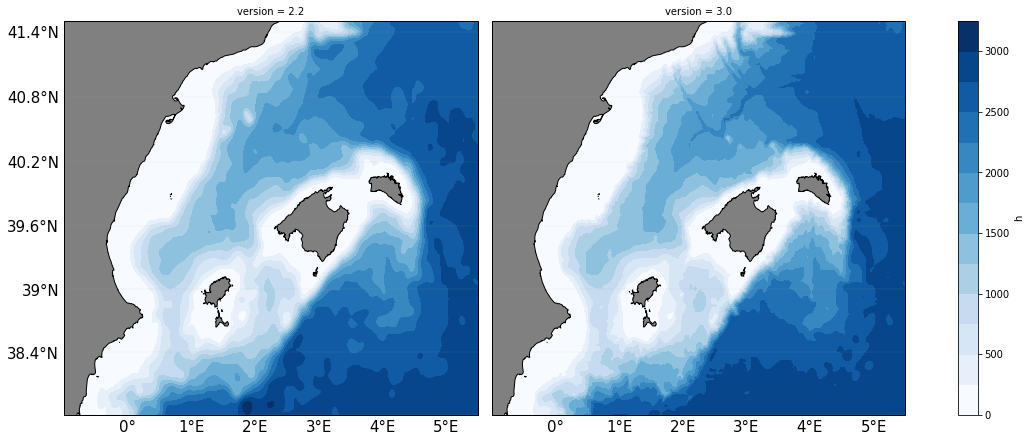

In [69]:
bathymetry.coords["version"] = list(['2.2','3.0'])
fc = bathymetry.plot.contourf(levels=15,x='lon_rho',y='lat_rho',sharey=True,col='version',cmap='Blues',figsize=[15,6],transform=dtr(),subplot_kws={'projection':ccrs.Mercator()})
draw_background_map('BalearicIslands', ax=fc.axes[0,0])
draw_background_map('BalearicIslands', ax=fc.axes[0,1],drawy=False)

## Nesting Regions

Two regions have been selected as a testing case for the nesting implementations in WMOP: both spans area of interest for recent campaigns. The first one is the PRE-SWOT area showed in fig, where are also showed the CTD sampling point (in green), the gliders transects or the sentinel passage? (yellow) and the drifters deployment points.

The CALYPSO one is represented in fig which shows

For both the nested grids we choosed the scaling factor as 5 so the resolutions achived is close to 400m.

# Grids Generation

Different software and scripts has been tested for preparing the new grids and the related contact files. In most of cases several difficulties occurred for the fact that there are a lot of not updated or not documented scripts. The solutions achieved at the end was a mix of MATLAB and python script covering all the aspects of the grid creation. We can resume that process in the following six steps:
 - Spatial area and parameters definition
 - Raw Grid Creation
 - Mask Refinement
 - Bathymetry Smoothing
 - Grid File Saving
 - Contact File Creation (only for nested grid)
 
each one is described in one of the following subsections with examples of the code used for the main grid generation and when different also for the PRE-SWOT grid. The python package necessary to run the following code are: pyROMS, basemap, scipy, numpy, netCDF4 and some specific functions written for WMOP collected in the package pyWMOP.

In [ ]:
import pyroms
import netCDF4 as nc4
from bathy_smoother import *
from mpl_toolkits.basemap import Basemap
from defaults import *
from wmop_grid import get_WMOP_grid

## Spatial area and parameters definition

As a first step the geographical area of the world spanned by the grid must be defined in terms of the south-north latitude range and the longitude east-west one. For the new main grid as said before we just decided to keep the same spatial limits of the old grid so for the moment we just need to load the old grid file.

In [ ]:
Lm = 140
Mm = 120

lon0=1.81 ; lat0 = 39.57
lon1=1.81 ; lat1 = 38.13
lon2 = 4.68 ; lat2 = 38.13
lon3 = 4.68 ; lat3 = 39.57
map = Basemap(projection='lcc', lat_0=35., lat_1=30., lat_2=40, lon_0 =123, \
              width=2000000, height=2000000, resolution='i')

lonp = np.array([lon0, lon1, lon2, lon3])
latp = np.array([lat0, lat1, lat2, lat3])
beta = np.array([1, 1, 1, 1])

#generate the new grid
# Do this if you aren't going to move the grid corners interactively.
hgrd = pyroms.grid.Gridgen(lonp, latp, beta, (Mm+3, Lm+3), proj=map)


In [ ]:
grid_dir = '/home/modelling/Softs/ROMS-3.4/WMOPv2.2/Grid/'
old_grid_filename = grid_dir + 'roms_grd_WMOPv2.0.nc'
oldgrid = get_WMOP_grid('WMOP-OLD',grid_file=old_grid_filename)

Regarding the nested grids once the longitudes and latitudes have been chosen the corresponding index (i and j) of the parent grid must be found. In the case of PRE-SWOT nested grid we have:

In [ ]:
min_lat = 38.13
max_lat = 39.57
min_lon = 1.81
max_lon = 4.68

and we then indivudate the following index with an usefull function from pyRoms:

In [ ]:
i_min, j_min = pyroms.utility.find_nearestgridpoints(min_lon,min_lat,oldgrid)[0]
i_max, j_max = pyroms.utility.find_nearestgridpoints(max_lon,max_lat,oldgrid)[0]

another fundamenal parameter is the scaling factor, in the PRE-SWOT capaign as already we choose:

In [ ]:
Gfactor = 5

Finally before passing to the raw grid generation the parameters concerning the sigma-coordinate vertical discretization should be defined. For more details concerning those parmeters check XXX.

In [ ]:
theta_b = 0.2
theta_s = 7.0
Tcline = 60
N = 32
hmin = 5
Lm = 629
Mm = 537

## Raw Grid Creation

Once defined the parameters it is possible to proceed to the generation of a "raw" version of the grid. Raw means, in that case, that the resulting grid does not present an high resolution land/sea mask, nor bathymetry. Those last ones in facts are just copied by the parent grid, so resulting quite coarse, as showed in the following figures:

Actually the fine masking is treated in the next step, while in this one the only relevant aspect is the definitions of the coordinates for the different points of the Arakawa grid. The attempt to do that with python causes errors when creating the contact files, so for the moment this part is still in MATLAB. The future's aim is to have a complete set of code in python. This problem could be related to different choices of the projections.

The script to call in MATLAB is named coarse2fine and is available through the official collections of Matlab script by in the new version of ROMS. The syntax for this command is te following:

    coarse2fine(Ginp,Gout,Gfactor,Imin,Imax,Jmin,Jmax)

where the parameters are:

-    Ginp       Input  coaser Grid NetCDF file name (character string)
-    Gout       Output finer  Grid NetCDF file name (character string)
-    Gfactor    Grid refinement factor (3,5,7,9,11,13,15,...)
-    Imin       Coarse grid lower-left  I-coordinate (PSI-point)
-    Imax       Coarse grid upper-right I-coordinate (PSI-point)
-    Jmin       Coarse grid lower-left  J-coordinate (PSI-point)
-    Jmax       Coarse grid upper-right J-coordinate (PSI-point)

The values to call this script to generate the raw version of PRE-SWOT nesting grid are the ones in the previous step.

Concerning the main grid of the model, this script was not necessary, because the points and the coordinates were just copied from the old version. In that way, as already said, a better retro-compatibility with the existing modelling facility codes is possible. In terms of code there are no significant difference, in the case of main grid we will load the old grid while in the nesting one the raw just created. Then we will make a copy of the horizontal structures.

In [ ]:
hgrd = pyroms.grid.CGrid_geo(oldgrid.hgrid.lon_vert, 
                             oldgrid.hgrid.lat_vert, 
                             oldgrid.hgrid.proj,
                             lat_rho=oldgrid.hgrid.lat_rho,
                             lon_rho=oldgrid.hgrid.lon_rho,
                             lat_psi=oldgrid.hgrid.lat_psi,
                             lon_psi=oldgrid.hgrid.lon_psi,
                             lat_u=oldgrid.hgrid.lat_u,
                             lon_u=oldgrid.hgrid.lon_u,
                             lat_v=oldgrid.hgrid.lat_v,
                             lon_v=oldgrid.hgrid.lon_v)

## Mask creation
To proper mask the points What the codes do basically is to download the coastlines from the XXX database and then check if every point of the grid is inside (i.e. over the ground then masked) or outside (i.e. over the sea so not masked).

The results achived in that way were quite good but still presents some inconsistency. A simple GUI inside the pyROMS toolbox then it is necessary to proceed with manual check and correction of the mask.  

In [ ]:
m = Basemap(projection='merc', 
            llcrnrlat=min_lat-1.0, urcrnrlat=max_lat+1.0,
            llcrnrlon=min_lon-1.0, urcrnrlon=max_lon+1.0, 
            lat_ts=-6., resolution='f',epsg=3395)

coast = pyroms.utility.get_coast_from_map(m)

In [ ]:
for xx,yy in m.coastpolygons:
    xa = np.array(xx, np.float32)
    ya = np.array(yy,np.float32)
    coastx,coasty = m(xa,ya, inverse=True)
    xa,ya = hgrd.proj(coastx,coasty)
    vv = np.zeros((xa.shape[0],2))
    vv[:, 0] = xa
    vv[:, 1] = ya
    hgrd.mask_polygon(vv,mask_value=0)

Those last two part of code are the same for both nested and the main grid but for this last one is usefull to include also the masking of the Cantabric Sea:

In [ ]:
#CANTABRIC SEA MASKINNG
lonlat_verts = [[-7.0,45.0],[-7.0,43.0],[0.0,43.0],[0,45.0]]
hgrd.mask_polygon_geo(lonlat_verts)

finally it is always better to proceed to a manual check of the masking and that is possible with an easy guy present in pyROMS and works in that way:

In [ ]:
%matplotlib auto

In [ ]:
pyroms.grid.edit_mask_
mesh_ij(hgrd, coast=coast)

## Bathymetry Insertion and Smoothing

As said before the bathymetry data cames from GEBCO and they are stored in a NetCDF file so they can be easily loaded:

In [ ]:
topography_filename = "/mnt/waverider/data/Data/Observations/BATHYMETRY/MED_GEBCO_30sec.nc"
nc = netCDF4.Dataset(topography_filename, 'r')
topo = nc.variables['elevation'][:]
lons = nc.variables['lon'][:]
lats = nc.variables['lat'][:]

then to allow a faster interpolation process we select just an area close to the one we need

In [ ]:
tm=1.0
clon = (lons>grid_limits[0]-tm) & (lons<grid_limits[1]+tm)
clat = (lats>grid_limits[2]-tm) & (lats<grid_limits[3]+tm)
lats = lats[clat]
lons = lons[clon]
topo = topo[clat][:,clon]

Now we have to interpolate the bathymetry data to the points of the grid

In [ ]:
points = np.dstack((np.repeat(lons,lats.shape),np.tile(lats,lons.shape)))[0]
fpoints = np.dstack((np.repeat(hgrd.lon_rho[0,:],hgrd.lat_rho[:,0].shape),np.tile(hgrd.lat_rho[:,0],hgrd.lon_rho[0,:].shape)))[0]
topo_interp = griddata(points, topo.transpose().flat[:], fpoints,method='linear')
topo_interp = topo_interp.reshape(hgrd.lon_rho.transpose().shape).transpose()

now we proceed with some final check

In [ ]:
topo = -topo

## insure that depth is always deeper than hmin
h = pyroms_toolbox.change(topo_interp, '<', hmin, hmin)

## set depth to hmin where masked
idx = np.where(hgrd.mask_rho == 0)
h[idx] = hmin

## save raw bathymetry
hraw = h.copy()

Also due to the previous step is possible that the resulting grid presents big difference of depth between close cells. For that reason a smooth of the bathymetry was necessary. As suggested in XXXX a roughness coefficient can be implemented to measure this phenomena. Once more with a python tools was possible to value this coefficient and automatically adjust the bathymetry until this requested value of roughness was reached. In this test this last was 0.25.

In [ ]:
rx0_max = 0.25

In [ ]:
# check bathymetry roughness
RoughMat = bathy_tools.RoughnessMatrix(h, hgrd.mask_rho)
print('Max Roughness value is: ', RoughMat.max())

In [ ]:
h = bathy_smoothing.smoothing_Positive_rx0(hgrd.mask_rho, h, rx0_max)

In [ ]:
RoughMat = bathy_tools.RoughnessMatrix(h, hgrd.mask_rho)
print('Max Roughness value is: ', RoughMat.max())

In [ ]:
vgrd = pyroms.vgrid.s_coordinate_4(h, theta_b, theta_s, Tcline, N, hraw=hraw)

## Grid File Savings

Finally now that the horizontal and the vertical grid structures are ready can be merged and saved in the grid file.

In [ ]:
grd = pyroms.grid.ROMS_Grid('NEW_GRID_NAME', hgrd, vgrd)
pyroms.grid.write_ROMS_grid(grd, final_grid_filename)

## Contact File Creation
The last step only regards the nested grids and concerns the contact points that as previosly said are processed outside of ROMS and saved in a NetCDF file. The script that permits that is in MATLAB and have the following syntax:

 CONTACT:  Sets Contact Points between ROMS nested Grids.

 [S,G] = contact(Gnames, Cname, Lmask, MaskInterp, Lplot)

 This function sets contact points in the overlaping contact
 regions between nested grids. The order of nested grid file
 names in input cell array (Gnames) is important.  Set the
 file names in the order of nesting layers and time-stepping
 in ROMS.

 On Input:

    Gnames      Input Grid NetCDF file names (cell array)

    Cname       Ouptut Contact Points NetCDF file name (string)

    Lmask       Switch to remove Contact Points over land
                  (default false)

    MaskInterp  Switch to interpolate PSI-, U- and V-masks (true) or
                  computed from interpolated RHO-mask (false) using
                  the "uvp_mask" script. We highly recommend for this
                  switch to always be false (default false)

    Lplot       Switch to plot various Contact Points figures
                  (default false)


# Nesting Outputs Analysis

With the new main grid covering the Western Mediterranean and the PRE-SWOT one a pre-operational simulation has been runned spanning all the month of May. To initialize this simulation a spinup from the forecast which includes data assimilation has been made, this is well described in other internal report and in XXX. The following analysis then compare the outputs from the forecast with assimilation, the nesting with the donor and the receiver fields and also a simulation without nesting but spanned by WMOPv3.0 to proper understand the effects of this upgrade.

This part of the report does not include the code used for generate the plots for better clarity, anyway an executable Jupther notebook with all the code is availabe.

In [1]:
from defaults import *

scrip.so not found. Remapping function will not be available


In [2]:
d_suf = '*20180*[5][0-1-2-3][0-8]'

In [3]:
ds_pool = {'WMOPv2.0 with Assimilation': 
               get_wmop_output_dataset('WMOP2.0_FORECAST_ASSIM',date_suffix=d_suf) ,
            'WMOPv3.0': 
               get_wmop_output_dataset('WMOP3.0',date_suffix=d_suf),
            'WMOPv3.0 with Nesting': 
               get_wmop_output_dataset('WMOP3.0_NESTING_PRESWOT_D',date_suffix=d_suf)}


/mnt/waverider/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_MFS_ASSIM/forecast_scratch/*20180*[5][0-1-2-3][0-8]_avg.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0/forecast_scratch/*20180*[5][0-1-2-3][0-8]_avg.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0_PRE-SWOT_nesting/forecast_scratch/*20180*[5][0-1-2-3][0-8]_avg.nc


In [4]:
ds_pool['WMOPv2.0 with Assimilation'] = ds_pool['WMOPv2.0 with Assimilation'].groupby('ocean_time').last(skipna=False)

In [5]:
nesting_ds = get_wmop_output_dataset('WMOP3.0_NESTING_PRESWOT_R',date_suffix=d_suf)

/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0_PRE-SWOT_nesting/forecast_scratch/*20180*[5][0-1-2-3][0-8]_PRE-SWOT_nest5_avg.nc


In [6]:
ds_his_pool = {'WMOPv2.0 with Assimilation': 
               get_wmop_output_dataset('WMOP2.0_FORECAST_ASSIM',date_suffix=d_suf,file_type='his') ,
            'WMOPv3.0': 
               get_wmop_output_dataset('WMOP3.0',date_suffix=d_suf,file_type='his'),
            'WMOPv3.0 with Nesting': 
               get_wmop_output_dataset('WMOP3.0_NESTING_PRESWOT_D',date_suffix=d_suf,file_type='his')}


/mnt/waverider/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_MFS_ASSIM/forecast_scratch/*20180*[5][0-1-2-3][0-8]_his.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0/forecast_scratch/*20180*[5][0-1-2-3][0-8]_his.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0_PRE-SWOT_nesting/forecast_scratch/*20180*[5][0-1-2-3][0-8]_his.nc


In [7]:
ds_his_pool['WMOPv2.0 with Assimilation'] = ds_his_pool['WMOPv2.0 with Assimilation'].groupby('ocean_time').last(skipna=False)

In [8]:
nesting_his_ds = get_wmop_output_dataset('WMOP3.0_NESTING_PRESWOT_R',date_suffix=d_suf,file_type='his')

/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0_PRE-SWOT_nesting/forecast_scratch/*20180*[5][0-1-2-3][0-8]_PRE-SWOT_nest5_his.nc


In [ ]:
ProgressBar().register()

### General Circulation

The first analysis concern the general circulation which is showed here for the region of the Baleric Islands with the sea surface height as background. The Nesting output is shown inside the black box close to Mallorca.

In [20]:
from matplotlib.colors import LogNorm,Normalize

In [9]:
ssh_pool = xr.concat([ds.zeta.mean(['ocean_time']) for name,ds in ds_pool.items()], dim='type')

In [45]:
u_nesting =  pyroms.utility.move2grid(nesting_ds.isel(s_rho=-1).mean(['ocean_time']).u,'u','psi').values
v_nesting =  pyroms.utility.move2grid(nesting_ds.isel(s_rho=-1).mean(['ocean_time']).v,'v','psi').values

In [12]:
u_pool =  [pyroms.utility.move2grid(ds.isel(s_rho=-1).mean(['ocean_time']).u,'u','psi') for name,ds in ds_pool.items()]
v_pool =  [pyroms.utility.move2grid(ds.isel(s_rho=-1).mean(['ocean_time']).v,'v','psi') for name,ds in ds_pool.items()]

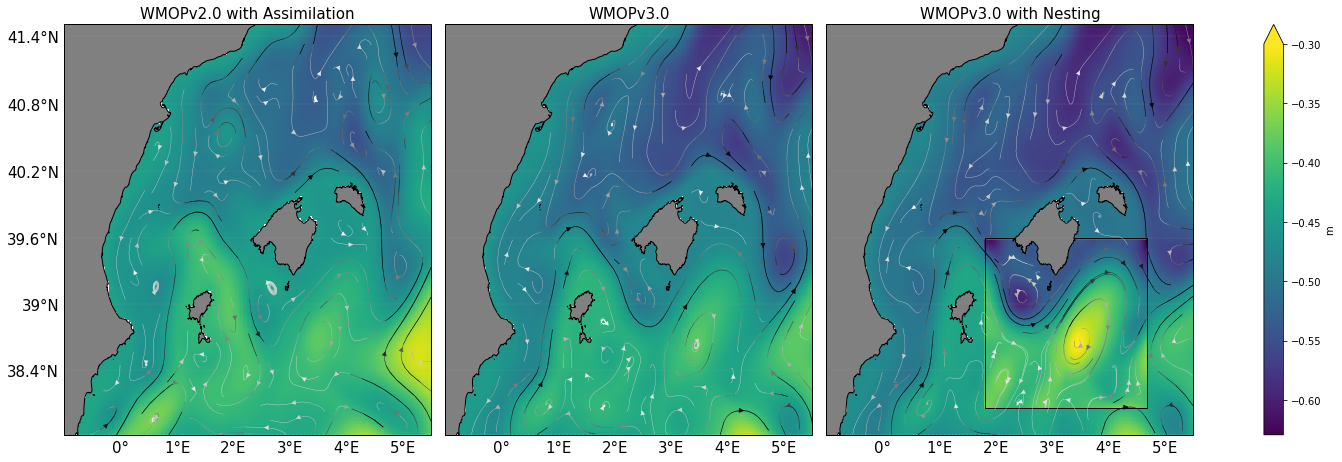

In [55]:
fc = ssh_pool.plot(vmax=-0.3,figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True,)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands',ax=ax,drawy=(i==0))
    u = u_pool[i].values
    v = v_pool[i].values
    m = np.sqrt(u**2+v**2)
    log_scale_factor = -1/np.log10(m/np.nanmax(m))
    lw = log_scale_factor*1/2
    lat_psi = pyroms.utility.move2grid(ssh_pool.lat_rho.values,'rho','psi')
    lon_psi = pyroms.utility.move2grid(ssh_pool.lon_rho.values,'rho','psi')
    ax.streamplot(lon_psi, lat_psi,u,v,color=m,norm=Normalize(0.01,0.2),linewidth=lw,transform=dtr(),cmap='Greys')
nesting_ds.zeta.mean(['ocean_time']).plot(ax=ax,add_colorbar=False,transform=dtr(),x='lon_rho', y='lat_rho')

m_nesting = np.sqrt(u_nesting**2+v_nesting**2)
log_scale_factor = -1/np.log10(m_nesting/np.nanmax(m))
lw = log_scale_factor*1/2
ax.streamplot(nesting_grd.hgrid.lon_psi, nesting_grd.hgrid.lat_psi,u_nesting,v_nesting,color=m_nesting,norm=Normalize(0.01,0.2),linewidth=lw,transform=dtr(),cmap='Greys')

draw_box(ax,region_name='PRE-SWOT')
ax.set_title('WMOPv3.0 with Nesting')
fc.set_titles(template='{value}',size=15)
fc.cbar.set_label('m')

it results that there are no discontinuties between the two grid of the nesting run and also between the differents simulations there are not big discrepancy. This normal behviour is also showed by the kinetic energy that is plotted in the following figure.

In [9]:
@vectorize([float64(float64, float64)])
def compute_ke(u,v):
    tke = ((u)**2+(v)**2)/2
    return tke

In [10]:
def get_geostrophic_velocities_from_ds(ds):
    g = 9.81; 
    omega = 7.292115 * 1e-5; 
    deg2meters = 60 * 1852;

    latCellSize = (np.diff(ds.lat_rho[:,0]) * deg2meters)
    latCellSize = np.hstack((latCellSize,latCellSize[-1]))
    latCellSize = np.matlib.repmat(latCellSize,ds.lat_rho.shape[1],1).transpose()
    lonCellSize = (np.diff(ds.lon_rho[0,:]) * deg2meters);
    lonCellSize = np.hstack((lonCellSize,lonCellSize[-1]))
    lonCellSize = lonCellSize * np.cos(np.deg2rad(ds.lat_rho))

    fcoriolis = 2 * omega * np.sin(np.deg2rad(ds.lat_rho));
    factor = g / fcoriolis;

    u_geo = pyroms.utility.move2grid(-factor*np.gradient(ds.zeta)[0]/lonCellSize,'rho','psi')
    u_geo = u_geo.rename({'eta_rho': 'eta_psi','xi_rho': 'xi_psi'})
    v_geo = pyroms.utility.move2grid(+factor*np.gradient(ds.zeta)[1]/latCellSize,'rho','psi')
    v_geo = v_geo.rename({'eta_rho': 'eta_psi','xi_rho': 'xi_psi'})
    return u_geo,v_geo

In [11]:
def get_geostrophic_ke_from_ds(ds):
    ke = 0
    i = 0
    for t,ds_t in ds.groupby('ocean_time',squeeze=False):
        u_geo, v_geo = get_geostrophic_velocities_from_ds(ds_t.isel(ocean_time=-1))
        ke +=   compute_ke(u_geo,v_geo)
        i += 1
    ke /= i
    print(i)
    return ke

In [12]:
def get_max_ke_diff_from_ds(ds):
    ke_mean = 0
    i = 0
    for t,ds_t in ds.groupby('ocean_time',squeeze=False):
        u_psi = (ds_t.isel(ocean_time=-1).u.loc[:,1:,:]+ds_t.u.isel(ocean_time=-1).loc[:,:-1,:])/2
        v_psi = (ds_t.isel(ocean_time=-1).v.loc[:,:,1:]+ds_t.v.isel(ocean_time=-1).loc[:,:,:-1])/2
        u_psi = u_psi.rename({'eta_u': 'eta_psi','xi_u': 'xi_psi'})
        v_psi = v_psi.rename({'eta_v': 'eta_psi','xi_v': 'xi_psi'})
        u_geo, v_geo = get_geostrophic_velocities_from_ds(ds_t.isel(ocean_time=-1))
        ke_d =   compute_ke(u_psi,v_psi).isel(s_rho=-1)-compute_ke(u_geo,v_geo)
        if ke_d.mean(['eta_psi','xi_psi']) > ke_mean:
            ke = ke_d
            ke_mean = ke_d.mean(['eta_psi','xi_psi'])
            print(t)
    return ke

In [13]:
def get_ke_from_geostrophy(zeta,subtract_mean=False):
    u_psi = (u.loc[:,:,1:,:]+u.loc[:,:,:-1,:])/2
    v_psi = (v.loc[:,:,:,1:]+v.loc[:,:,:,:-1])/2
    u_psi = u_psi.rename({'eta_u': 'eta_psi','xi_u': 'xi_psi'})
    v_psi = v_psi.rename({'eta_v': 'eta_psi','xi_v': 'xi_psi'})
    if subtract_mean:
        u_anomaly = u_psi - u_psi.mean('ocean_time')
        v_anomaly = v_psi - v_psi.mean('ocean_time')
        return compute_ke(u_anomaly,v_anomaly)
    else:
        return compute_ke(u_psi,v_psi)

In [14]:
def get_ke_from_uv(u,v,subtract_mean=False):
    u_psi = (u.loc[:,:,1:,:]+u.loc[:,:,:-1,:])/2
    v_psi = (v.loc[:,:,:,1:]+v.loc[:,:,:,:-1])/2
    u_psi = u_psi.rename({'eta_u': 'eta_psi','xi_u': 'xi_psi'})
    v_psi = v_psi.rename({'eta_v': 'eta_psi','xi_v': 'xi_psi'})
    if subtract_mean:
        u_anomaly = u_psi - u_psi.mean('ocean_time')
        v_anomaly = v_psi - v_psi.mean('ocean_time')
        return compute_ke(u_anomaly,v_anomaly)
    else:
        return compute_ke(u_psi,v_psi)

In [15]:
ke_pool = xr.concat([get_ke_from_uv(ds.u,ds.v).isel(s_rho=-1).mean(['ocean_time']) for name,ds in ds_pool.items()], dim='type')

In [16]:
ke_pool.coords["type"] = list(ds_pool.keys())

In [17]:
ke_nesting = get_ke_from_uv(nesting_ds.u,nesting_ds.v).isel(s_rho=-1).mean(['ocean_time'])

In [18]:
ke_nesting.coords["lon_psi"] = nesting_ds.lon_psi
ke_nesting.coords["lat_psi"] = nesting_ds.lat_psi

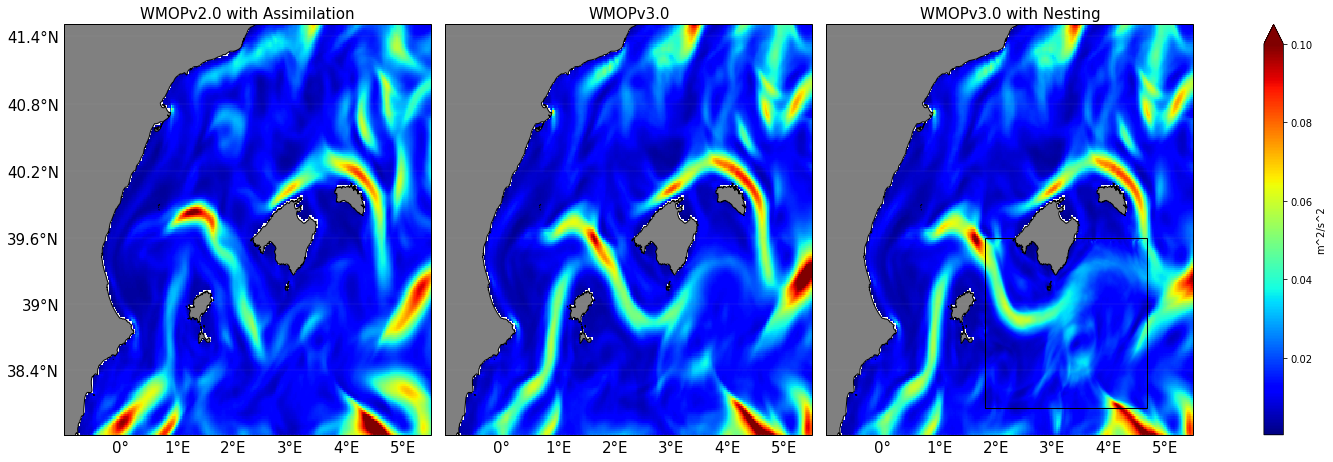

In [19]:
fc = ke_pool.plot(figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_u', y='lat_v',vmax=0.1,cmap='jet',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True,)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands',ax=ax,drawy=(i==0))
ke_nesting.plot(ax=ax,vmax=0.1,cmap='jet',add_colorbar=False,transform=dtr(),x='lon_psi', y='lat_psi')
draw_box(ax,region_name='PRE-SWOT')
ax.set_title('WMOPv3.0 with Nesting')
fc.set_titles(template='{value}',size=15)
fc.cbar.set_label('m^2/s^2')

### Salinity and Temperature

A better comprension of the potentiality of nesting is evidencied by the plots of the two active tracers considered in the model: the temperature and the salinity. Starting from the latter and considering the average over the whole period we obtain the figure X. It is possible to see how in the PRE-SWOT region appear a water mass mixing. What can be osserved also is that with the nesting the salinity front is better represented.

In [25]:
salt_pool = xr.concat([ds.salt.mean(['ocean_time']).isel(s_rho=-1) for name,ds in ds_pool.items()], dim='type')
salt_pool.coords["type"] = list(ds_pool.keys())

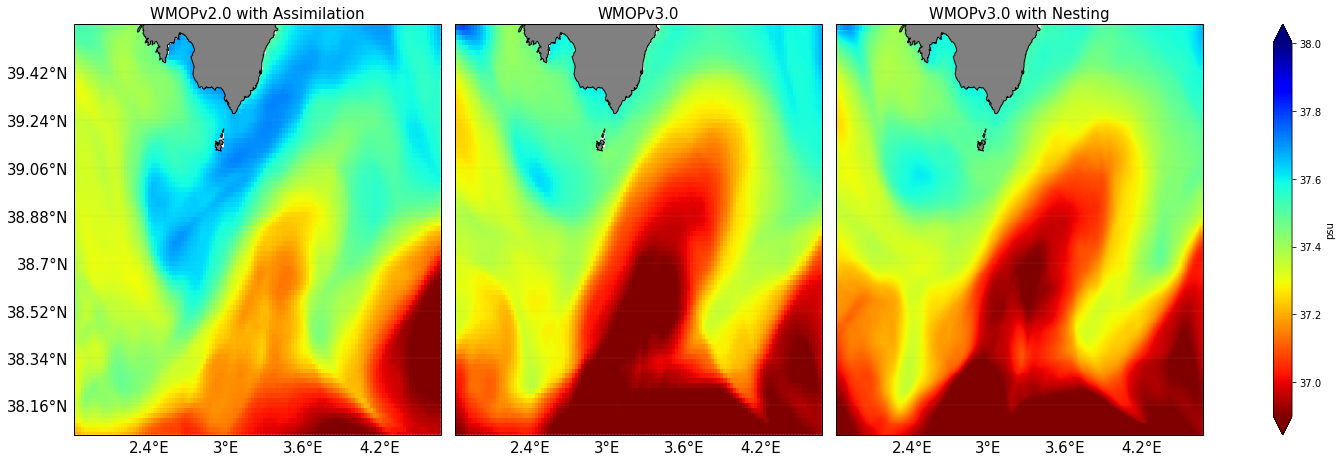

In [26]:
fc = salt_pool.plot(vmax=38,vmin=36.9,figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',cmap='jet_r',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('PRE-SWOT',ax=ax,drawy=(i==0))
nesting_ds.mean(['ocean_time']).isel(s_rho=-1).salt.plot(cmap='jet_r',ax=ax,x='lon_rho',y='lat_rho',transform=dtr(),vmax=38,vmin=36.9,add_colorbar=False,)
ax.set_title('WMOPv3.0 with Nesting')
fc.set_titles(template='{value}',size=15)
fc.cbar.set_label('psu')

In [27]:
temp_pool = xr.concat([ds.temp.mean(['ocean_time']).isel(s_rho=-1) for name,ds in ds_pool.items()], dim='type')
temp_pool.coords["type"] = list(ds_pool.keys())

The temperature plot here following do not show particular difference between the runs but it is intersting to note how the nesting simulation is closer to the assimilated one.

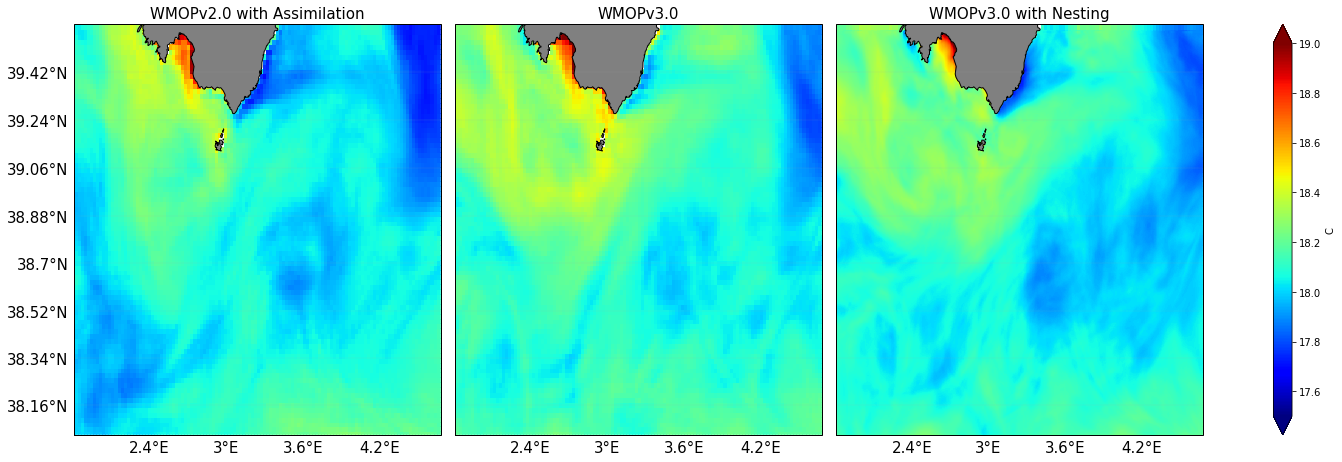

In [99]:
fc = temp_pool.plot(vmax=19,vmin=17.5,figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',cmap='jet',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('PRE-SWOT',ax=ax,drawy=(i==0))
nesting_ds.mean(['ocean_time']).isel(s_rho=-1).temp.plot(vmax=19,vmin=17.5,cmap='jet',ax=ax,x='lon_rho',y='lat_rho',transform=dtr(),add_colorbar=False,)
fc.cbar.set_label('C')
ax.set_title('WMOPv3.0 with Nesting')
fc.set_titles(template='{value}',size=15)

### Vorticity (Rossby N)

One hypothesis that has been considered regards the possibity that the nesting simulations presents a stronger ageostrophic velocity components. To verify that the Rossby Number has been computed as the modulus of the relative vorticity scaled with the planetary vorticity. The results of this calculus averaged over all the simulations period is showed in the following figure:

It is possible to see how the coastal region of Mallorca presents higher values of $R_N$ in the nesting run, this could be motivated by wind effects and the better masking obtained increasing the resolutions of the grid. Other intersting region is the center of the modelled area that will be further investigated. 

In [347]:
def get_vorticity_from_roms_ds(ds,grd,depth=5):
    u_zslice = pyroms.tools.zslice(ds.u,depth,grd,Cpos='u')[0]
    v_zslice = pyroms.tools.zslice(ds.v,depth,grd,Cpos='v')[0]
    u_psi = pyroms.utility.move2grid(u_zslice,'u','psi')
    v_psi = pyroms.utility.move2grid(v_zslice,'v','psi')
    dx_psi = pyroms.utility.move2grid(grd.hgrid.dx,'rho','psi')
    dy_psi = pyroms.utility.move2grid(grd.hgrid.dy,'rho','psi')
    UUX,UUY = np.gradient(u_psi)
    VVX,VVY = np.gradient(v_psi)    
    omega=7.2921E-5
    f_matrix=2*omega*np.sin(np.deg2rad(ds.lat_psi))
    vorticity=xr.DataArray((VVX/dx_psi-UUY/dy_psi)/f_matrix,ds.lat_psi.coords);
    return np.abs(vorticity)

In [348]:
def get_mean_rossbyn_from_ds(ds,grd):
    vort = 0
    i = 0
    for t,ds_t in ds.groupby('ocean_time',squeeze=False):
        vort += np.abs(get_vorticity_from_roms_ds(ds_t.isel(ocean_time=-1),grd))
        i += 1
    vort /= i
    print(i)
    return vort

In [40]:
from wmop_grid import *

In [370]:
vort_pool = xr.concat([get_mean_rossbyn_from_ds(ds.sel(ocean_time=sdate),get_WMOP_grid('',grid_file=ds.grd_file)) for name,ds in ds_his_pool.items()], dim='type')

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file
8
Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file
8
Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file
8


In [41]:
nesting_grd = get_WMOP_grid('N',grid_file=nesting_ds.grd_file)

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [371]:
vort_nesting = get_mean_rossbyn_from_ds(nesting_his_ds.sel(ocean_time=sdate),nesting_grd)

8


In [353]:
vort_pool.coords["type"] = list(ds_pool.keys())

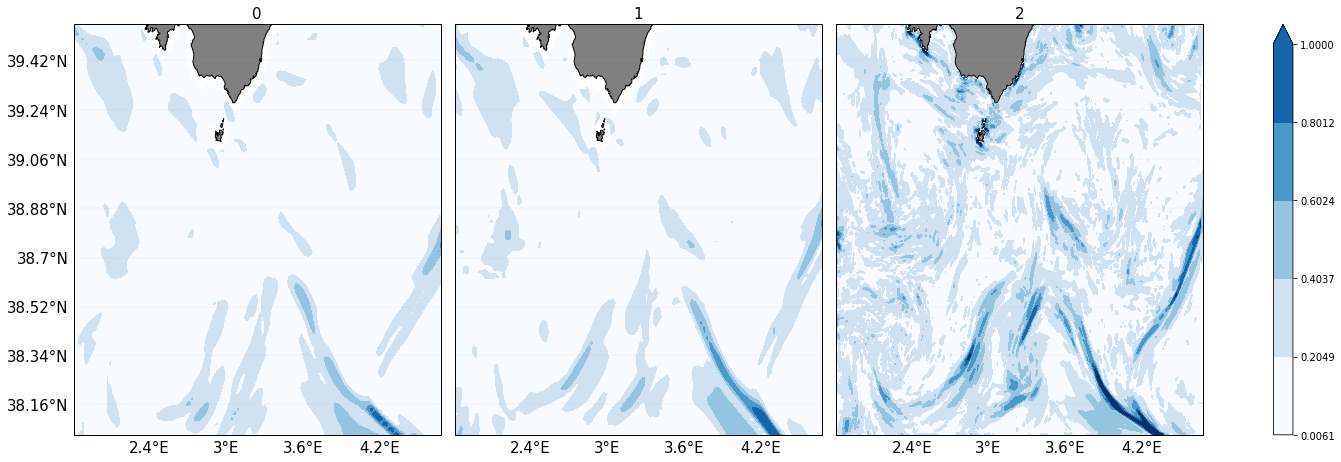

In [373]:
fc = vort_pool.plot.contourf(levels=6,cmap='Blues',vmax=1,figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_psi', y='lat_psi',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True)
for i,ax in enumerate(fc.axes[0,:]):
    #ax.clabel(fc, fc.levels, inline=True, fontsize=15,color='k')
    draw_background_map('PRE-SWOT2',zone_limits=[1.805,4.68,38.047,39.55],ax=ax,drawy=(i==0))
fc.set_titles(fontsize=15)
vort_nesting.plot.contourf(cmap='Blues',levels=6,ax=ax,transform=dtr(),x='lon_psi', y='lat_psi',add_colorbar=False,vmax=1)
ax.set_title('WMOPv3.0 with Nesting')
fc.set_titles(template='{value}',size=15)

### Vertical Velocities

Regarding vertical velocities the most relevant fact introduced by the nesting is the presence of higher values both for descending and ascending velocities. In the following histogram is shown how the vertical velocites are distributed for the different run of the model. The green one, the one from the nesting, shows how there are more vertical velocities up to 60 m/day in that run. 

In [368]:
sdate = '2018-05-10'

In [331]:
w_pool = xr.concat([xr.DataArray(pyroms.tools.zslice(
                                ds.sel(ocean_time=sdate).w,
                                15,
                                get_WMOP_grid('',grid_file=ds.grd_file),
                                Cpos='w')[0],
                    ds.lat_rho.coords) for name,ds in ds_his_pool.items()], dim='type')

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file
Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file
Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [332]:
w_pool.coords["type"] = list(ds_pool.keys())

In [336]:
w_nesting = xr.DataArray(pyroms.tools.zslice(nesting_his_ds.w.sel(ocean_time=sdate),15,nesting_grd,Cpos='w')[0],nesting_ds.lat_rho.coords)

In [357]:
nonesting_ds = select_roms_dataset_region(ds_his_pool['WMOPv3.0'],region_name='PRE-SWOT')

In [339]:
w_distributions = [select_roms_dataset_region(ds,region_name='PRE-SWOT').w.sel(ocean_time=sdate).values*24*60*60 for name,ds in ds_his_pool.items()]
w_distributions = [w[~np.isnan(w)] for w in w_distributions]

In [342]:
w_distributions[2] = nesting_his_ds.w.sel(ocean_time=sdate).values*24*60*60
w_distributions[2] = w_distributions[2][~np.isnan(w_distributions[2])]

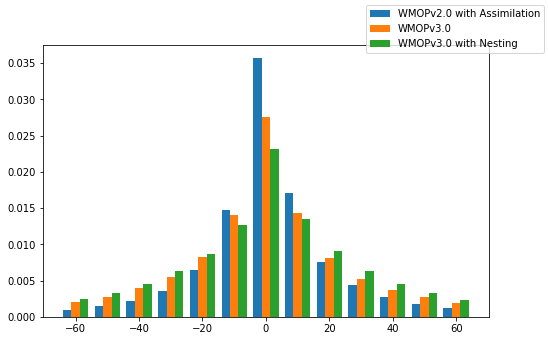

In [345]:
fig = plt.figure(figsize=(8,5))
fig.gca().hist(w_distributions,bins=np.arange(-65.0,75.0, 10),normed=1,alpha=1, label=list(ds_pool.keys()))
fig.legend()

This is also confirmed by the following plots wich represents the plots of the same snapshot used to compute the histogram. Once more is possible to see how with the nesting we can model smaller structures.

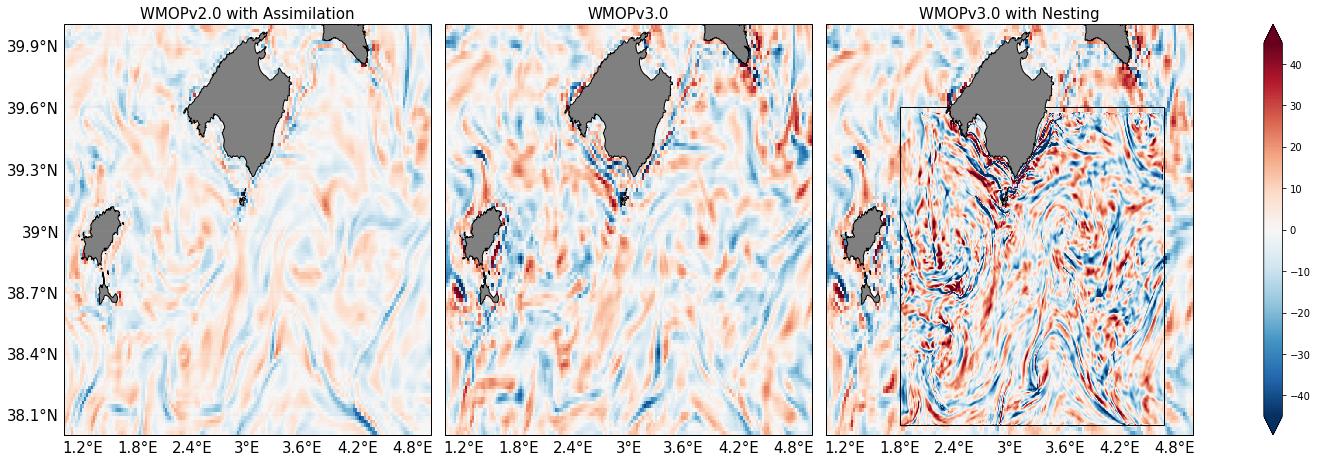

In [346]:
fc = (w_pool*24*60*60).plot(vmax=45,figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands2',ax=ax,drawy=(i==0))
fc.set_titles(fontsize=15)
(w_nesting*24*60*60).plot(vmax=45,ax=ax,transform=dtr(),x='lon_rho', y='lat_rho',add_colorbar=False)
ax.set_title('WMOPv3.0 with Nesting')
draw_box(ax,region_name='PRE-SWOT')
fc.set_titles(template='{value}',size=15)

### Spatial Power Spectrum

Lastly an analysis regarding the spatial power spectrum has been conducted over the surface kinetic energies. The region for doing that kind of analysis is inevitably smaller than the nesting one because it should be a retangular that do not present land point (i.e. nan value of the fields), then the coordinates are (first the longitudes and the the latitudes):

In [65]:
spectral_analysis_region_limits = [[1.7,4.7,38.04,39.1]]

and then here following the resulting spectrum with also two regression: one for the nesting and the other for the original version of WMOP

In [47]:
import PowerSpec as ps
from wmop_grid import *

In [48]:
def compute_spatial_spectrum_from_roms_ds(data,pos='rho'):
    cpos = {'psi':['lon_psi','lat_psi'],'rho':['lon_rho','lat_rho'],'ke':['lon_u','lat_v']}
    lon_var = data.coords.get(cpos[pos][0])
    lat_var = data.coords.get(cpos[pos][1])
    kspec,pspec_mean = 0,0
    
    for t in data.ocean_time:
        ddata = data.sel(ocean_time=t.values,drop=True)
        x,y,idata = ps.interpolate(ddata,lon_var,lat_var,interp=None)
        kspec ,pspec = ps.get_spectrum(idata,x,y)
        pspec_mean += pspec
    pspec_mean /= data.ocean_time.shape[0]
    return kspec,pspec_mean

In [66]:
spectral_pool = [select_roms_dataset_region(ds,region_limits=spectral_analysis_region_limits) for name,ds in ds_pool.items()]

In [67]:
nesting_spectral_ds = select_roms_dataset_region(nesting_ds,region_limits=spectral_analysis_region_limits)

In [68]:
ke_spectral_pool = [get_ke_from_uv(ds.u,ds.v) for ds in spectral_pool]

In [69]:
nesting_ke_ds = get_ke_from_uv(nesting_spectral_ds.u,nesting_spectral_ds.v).isel(s_rho=-1)

In [70]:
nesting_ke_ds.coords["lon_psi"] = nesting_spectral_ds.lon_psi
nesting_ke_ds.coords["lat_psi"] = nesting_spectral_ds.lat_psi

In [71]:
nesting_ke_spectrum = compute_spatial_spectrum_from_roms_ds(nesting_ke_ds,pos='psi')

In [72]:
spectrum = [compute_spatial_spectrum_from_roms_ds(ke.isel(s_rho=-1),pos='ke') for ke in ke_spectral_pool]

In [73]:
from scipy import stats

In [74]:
def get_spectrum_plot(label=None,use_ax=None):
	if not use_ax:
		fig = plt.figure(figsize=(10, 10))
		ax1 = fig.add_subplot(111)
	else:
		ax1 = use_ax
	ax2 = ax1.twiny()
	ax1.grid(True)
	ax1.legend()

    #plt.ylim([1e-7, 1e4])
	ax1.set_xlabel('Wavenumber')
	ax1.set_ylabel('Power Spectral Density')
	wl = [150,75,25,10,5,1,0.5]
	ax1.set_xticks(1/(np.array(wl)*1000))

	def tick_function(X):
		W = 1. / (X)/1000
		return ["%.3f" % z for z in W]

	ax2.set_xscale('log')
	ax2.set_xticks(ax1.get_xticks())
	ax2.set_xticklabels(tick_function(ax1.get_xticks()))
	ax2.set_xlabel("Wavelength")
	ax2.grid(b=True, which='minor', color='w', linestyle='--')
	return fig,ax1,ax2

No handles with labels found to put in legend.


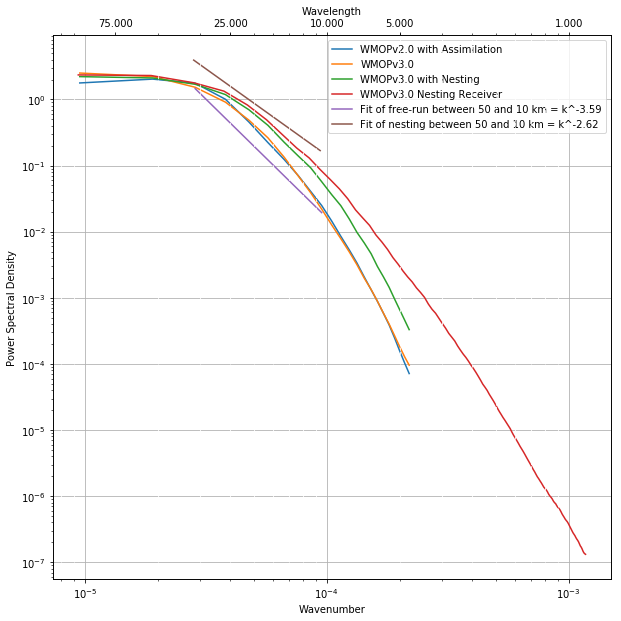

In [103]:
fig,ax1,ax2 = get_spectrum_plot()
for i,s in enumerate(spectrum):
    title = 'Spectrum for SSH Mean in NATL60 over May 2013'
    ax1.loglog(s[0], s[1],label=list(ds_pool.keys())[i])
ax1.loglog(nesting_ke_spectrum[0], nesting_ke_spectrum[1],label='WMOPv3.0 Nesting Receiver')
#ax1.loglog(nesting_ke_spectrum[0],nesting_ke_spectrum[0]**(-3)/10**13.2,'k-',label=r'$k^{-5}$')

to_fit = [spectrum[1][0],spectrum[1][1]]
to_fit[1] = to_fit[1][np.logical_and((1/to_fit[0]/1000)<50,(1/to_fit[0]/1000)>10)]
to_fit[0] = to_fit[0][np.logical_and((1/to_fit[0]/1000)<50,(1/to_fit[0]/1000)>10)]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(to_fit[0]),np.log10(to_fit[1]))
line = slope*np.log10(to_fit[0])+intercept-0.2
ax1.plot(to_fit[0],10**line, label='Fit of free-run between 50 and 10 km = k^{:.2f}'.format(slope,intercept))

to_fit = [nesting_ke_spectrum[0],nesting_ke_spectrum[1]]
to_fit[1] = to_fit[1][np.logical_and((1/to_fit[0]/1000)<50,(1/to_fit[0]/1000)>10)]
to_fit[0] = to_fit[0][np.logical_and((1/to_fit[0]/1000)<50,(1/to_fit[0]/1000)>10)]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(to_fit[0]),np.log10(to_fit[1]))
line = slope*np.log10(to_fit[0])+intercept+0.2
ax1.plot(to_fit[0],10**line, label='Fit of nesting between 50 and 10 km = k^{:.2f}'.format(slope,intercept))

#ax1.set_xbound(10**-5,10**-4.9)
ax2.set_xbound((ax1.get_xbound()))
#ax2.set_xbound(1/(np.array([75,25])*100))
ax1.legend()


It is evident from the plot in figure XXX that the energy cascade of the nesting runs follow a less steep beahviour. In particular with the two regression from 50 to 10km we see how the nesting presents a value compatible with the literature: $k^{-8/3}$ XXX while the other runs are in the dissipation scale $k^{<-3}$. It was possible to fit the orange spectrum with a $k^{-8/3}$ law just up to 15km so this could be defined the effective resolution of the WMOP withouth nesting.

### Final Remarks

Considering all the treathed analysis the nesting capabilities implemented in ROMS 3.7 and then in WMOPv3.0 offers good opportunities to better modelize mesoscale and submesoscale phenomena.

No discrepancies appears in a long period run but it is important to remarks that in the first days (5 more or less) of the WMOPv3.0 runs (both with and without nesting) some waves appear in the domain. This could be caused from the spinup operation that need an interpolation between two differents grids and it should be further investigated.


In [364]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')